# Differential expression analysis in single cell

Sometimes we need to compare differentially expressed genes or differentially expressed features between two cell types on single cell data, but existing methods focus more on cell-specific gene analysis. Researchers need to transfer bulk RNA-seq analysis to single-cell analysis, which involves interaction between different programming languages or programming tools, adding significantly to the workload of the researcher.
Here, we use omicverse's bulk RNA-seq pyDEG method to complete differential expression analysis at the single cell level.

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv

ov.utils.ov_plot_set()

/Users/fernandozeng/miniforge3/envs/scbasset/lib/python3.8/site-packages/phate/__init__.py


## Data preprocessed 

We need to normalized and scale the data at first.

In [43]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [44]:
adata.X.max()

2286.0

We found that the max value of anndata object larger than 10 and type is int. We need to normalize and log1p it

In [45]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [46]:
adata.X.max()

60.778294

## Different expression object

We then select the target cells to be analysed, including `Alpha` and `Beta`, derive the expression matrix using `to_df()` and build the differential expression analysis module using `pyDEG`

In [47]:
test_adata=adata[adata.obs['clusters'].isin(['Alpha','Beta'])]
test_adata

View of AnnData object with n_obs × n_vars = 1072 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes', 'mean', 'std'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [48]:
dds=ov.bulk.pyDEG(test_adata.to_df().T)

In [49]:
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


We also need to set up an experimental group and a control group, i.e. the two types of cells to be compared and analysed

In [50]:
treatment_groups=test_adata.obs[test_adata.obs['clusters']=='Alpha'].index.tolist()
control_groups=test_adata.obs[test_adata.obs['clusters']=='Beta'].index.tolist()
result=dds.deg_analysis(treatment_groups,control_groups,method='ttest')


In [55]:
result.sort_values('qvalue').head()

,pvalue,qvalue,FoldChange,-log(pvalue),-log(qvalue),BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,sig
index,,,,,,,,,,,
Itgam,0.0,0.0,0.999995,inf,10.0,-0.032817,NaN,-0.000007,0.000007,0.100000,normal
Ccl2,0.0,0.0,1.000002,inf,10.0,-0.022010,NaN,0.000003,0.000003,0.100000,normal
Smoc2,0.0,0.0,0.999995,inf,10.0,-0.266641,NaN,-0.000007,0.000007,0.099999,normal
1700020L24Rik,0.0,0.0,1.000003,inf,10.0,-0.042069,NaN,0.000004,0.000004,0.100000,normal
Tbxa2r,0.0,0.0,0.999998,inf,10.0,-0.043249,NaN,-0.000003,0.000003,0.100000,normal


In [51]:
# -1 means automatically calculates
dds.foldchange_set(fc_threshold=-1,
                   pval_threshold=0.05,
                   logp_max=10)

... Fold change threshold: 1.502500295639038


<Axes: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

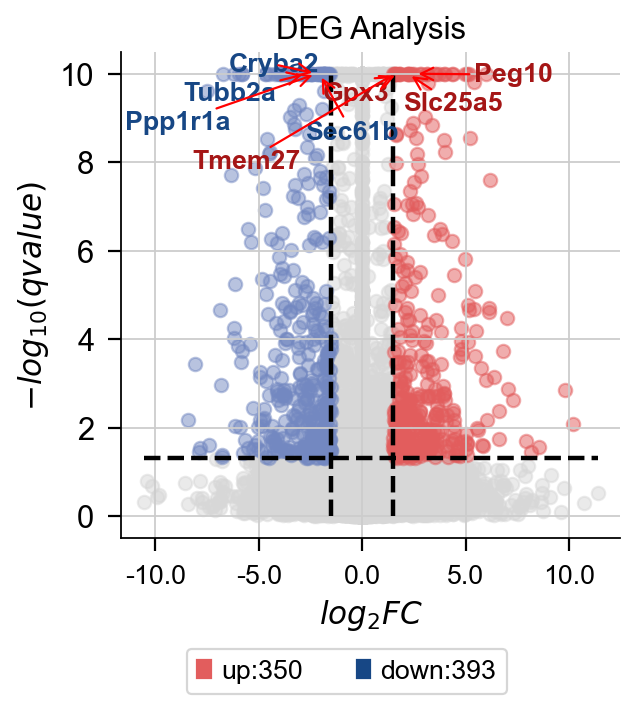

In [52]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

(<Figure size 160x240 with 1 Axes>,
 <Axes: title={'center': 'Gene Expression'}>)

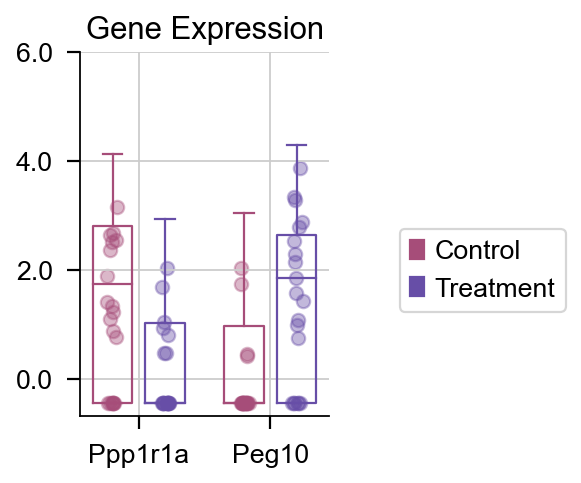

In [53]:
dds.plot_boxplot(genes=['Peg10','Ppp1r1a'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))